# Predicting House Prices

## 1. Import Libraray

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from xgboost import XGBRegressor

In [3]:
from pathlib import Path
import sys
# Add project root so "from configs import config" works
sys.path.append(str(Path.cwd().resolve().parents[0]))

from configs import config
import pandas as pd
df = pd.read_csv(config.RAW_DATA)

## Phase 2 — Split first, then preprocess with a Pipeline (no leakage)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, PowerTransformer
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from configs import config

# 1) Split FIRST (prevents leakage)
X = df.drop(columns=[config.TARGET])
y = df[config.TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=config.TEST_SIZE, random_state=config.SEED
)

# 2) Column selectors
num_sel = make_column_selector(dtype_include=np.number)
cat_sel = make_column_selector(dtype_include=["object", "category", "bool"])

# 3) Preprocessing blocks
num_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    # Systematic outlier/skew handling without manual clipping:
    ("yeojohnson", PowerTransformer(method="yeo-johnson", standardize=True)),
])

cat_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_sel),
        ("cat", cat_pipe, cat_sel),
    ],
    remainder="drop",
)

## Phase 3 — Add a dumb baseline + tidy metrics (quick win)

In [8]:
def evaluate(model, X_tr, y_tr, X_te, y_te, name="model"):
    model.fit(X_tr, y_tr)
    preds = model.predict(X_te)
    mae = mean_absolute_error(y_te, preds)
    rmse = mean_squared_error(y_te, preds)
    r2 = r2_score(y_te, preds)
    print(f"[{name}] MAE={mae:,.2f} | RMSE={rmse:,.2f} | R²={r2:.4f}")
    return {"name": name, "MAE": mae, "RMSE": rmse, "R2": r2}

dummy = Pipeline([("prep", preprocess), ("model", DummyRegressor(strategy="median"))])
baseline_metrics = evaluate(dummy, X_train, y_train, X_test, y_test, "DUMMY_median")


[DUMMY_median] MAE=59,568.25 | RMSE=7,861,866,593.52 | R²=-0.0250


## Phase 4 — Proper Linear Regression and working XGBoost

In [9]:
linreg = Pipeline([
    ("prep", preprocess),
    ("model", LinearRegression())
])
lr_metrics = evaluate(linreg, X_train, y_train, X_test, y_test, "LinearRegression")

xgb = Pipeline([
    ("prep", preprocess),
    ("model", XGBRegressor(
        objective="reg:squarederror",
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=config.SEED,
        tree_method="hist",
        n_jobs=-1,
    ))
])
xgb_metrics = evaluate(xgb, X_train, y_train, X_test, y_test, "XGB_default")

[LinearRegression] MAE=27,077.81 | RMSE=17,011,181,193.82 | R²=-1.2178
[XGB_default] MAE=15,427.96 | RMSE=611,784,768.00 | R²=0.9202


## Phase 5 — Cross-validation + hyperparameter search (robust evaluation)

In [10]:
from sklearn.model_selection import cross_val_score, KFold

cv = KFold(n_splits=config.CV_FOLDS, shuffle=True, random_state=config.SEED)
cv_rmse = -cross_val_score(xgb, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error")
print("XGB CV RMSE:", np.round(cv_rmse, 3), "mean:", cv_rmse.mean().round(3))

XGB CV RMSE: [25964.176 33024.684 36624.895 22963.674 23230.701] mean: 28361.626


In [11]:
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    "model__n_estimators": [300, 500, 800, 1200],
    "model__max_depth": [4, 6, 8, 10],
    "model__learning_rate": [0.03, 0.05, 0.07, 0.1],
    "model__subsample": [0.7, 0.8, 0.9, 1.0],
    "model__colsample_bytree": [0.7, 0.8, 0.9, 1.0],
    "model__reg_alpha": [0, 0.001, 0.01, 0.1],
    "model__reg_lambda": [0.1, 0.5, 1.0, 2.0, 5.0],
}

search = RandomizedSearchCV(
    xgb, param_distributions=param_distributions,
    n_iter=30, scoring="neg_root_mean_squared_error",
    cv=cv, n_jobs=-1, random_state=config.SEED, verbose=1
)
search.fit(X_train, y_train)  # no early stopping inside CV

print("Best CV RMSE:", (-search.best_score_)**0.5)
print("Best params:", search.best_params_)
best_xgb = search.best_estimator_


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best CV RMSE: 162.9682915861242
Best params: {'model__subsample': 0.7, 'model__reg_lambda': 0.1, 'model__reg_alpha': 0.001, 'model__n_estimators': 300, 'model__max_depth': 4, 'model__learning_rate': 0.05, 'model__colsample_bytree': 0.8}


## Phase 6 — Smarter EDA (replace the spammy loops)

In [12]:
# Top 12 numeric correlations with target
num_cols = df.select_dtypes(include=np.number).columns.drop(config.TARGET)
corr = df[num_cols].corrwith(df[config.TARGET]).abs().sort_values(ascending=False).head(12)
display(corr.to_frame("abs_corr_with_target"))

# Few categorical counts for the most frequent cats
cat_cols = df.select_dtypes(include=["object","category","bool"]).columns
for c in cat_cols[:5]:  # limit to a few important ones
    display(df[c].value_counts().head(10))


,abs_corr_with_target
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897
YearRemodAdd,0.507101


MSZoning
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: count, dtype: int64

Street
Pave    1454
Grvl       6
Name: count, dtype: int64

Alley
Grvl    50
Pave    41
Name: count, dtype: int64

LotShape
Reg    925
IR1    484
IR2     41
IR3     10
Name: count, dtype: int64

LandContour
Lvl    1311
Bnk      63
HLS      50
Low      36
Name: count, dtype: int64

## Phase 7 — Clean visualization: predicted vs. actual

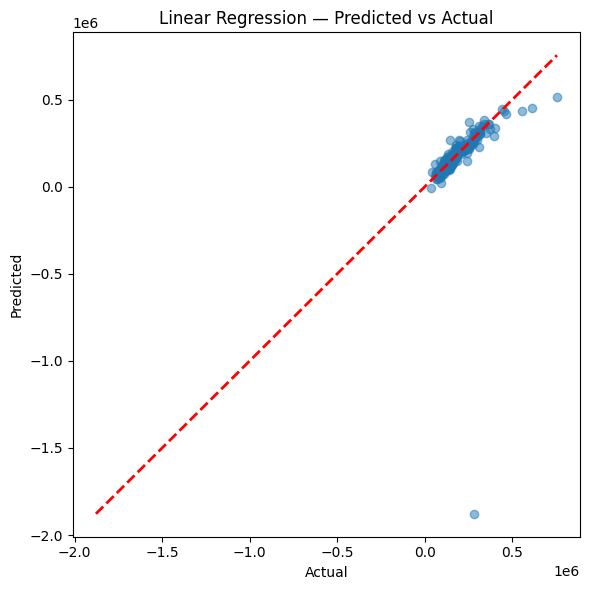

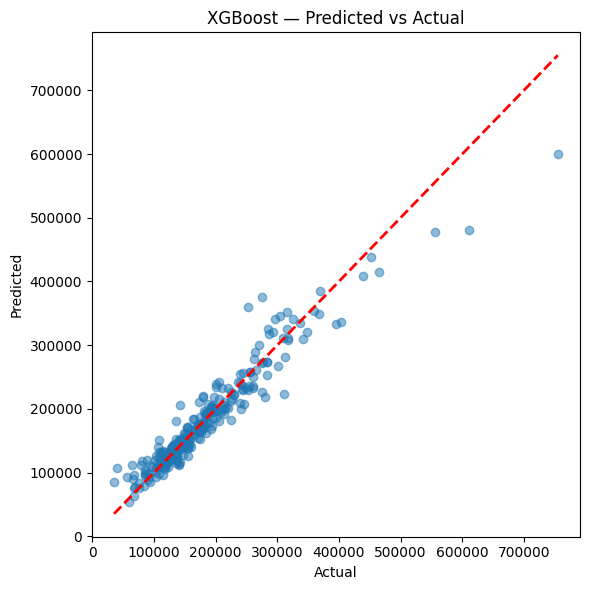

In [14]:
def plot_pred_vs_actual(y_true, y_pred, title):
    plt.figure(figsize=(6,6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
    plt.plot(lims, lims, "r--", linewidth=2)
    plt.xlabel("Actual"); plt.ylabel("Predicted"); plt.title(title)
    plt.tight_layout(); plt.show()

# ---- Linear Regression ----
y_pred_lr = linreg.predict(X_test)
plot_pred_vs_actual(y_test, y_pred_lr, "Linear Regression — Predicted vs Actual")

# ---- XGBoost ----
y_pred_xgb = xgb.predict(X_test)
plot_pred_vs_actual(y_test, y_pred_xgb, "XGBoost — Predicted vs Actual")


## Phase 8 — Minimal experiment tracking (CSV logger now; MLflow later)

In [15]:
import time

def log_experiment(row: dict, csv_path=config.EXPERIMENTS_CSV):
    row = {"ts": time.strftime("%Y-%m-%d %H:%M:%S"), **row}
    csv_path = Path(csv_path)
    if csv_path.exists():
        pd.DataFrame([row]).to_csv(csv_path, mode="a", header=False, index=False)
    else:
        pd.DataFrame([row]).to_csv(csv_path, index=False)

# Example logging
log_experiment({
    "model": "XGB(best_random_search)",
    **xgb_metrics  # or recompute with best_xgb
})


## Phase 9 — Save artifact (serialize the whole pipeline)

In [16]:
import joblib, uuid

config.MODELS_DIR.mkdir(parents=True, exist_ok=True)
model_path = config.MODELS_DIR / f"xgb_pipeline_{uuid.uuid4().hex[:8]}.joblib"
joblib.dump(best_xgb, model_path)
print("Saved:", model_path)


Saved: /Users/trevionnowakowski/Code/houseprice_prediction/models/xgb_pipeline_50e3381c.joblib


## Phase 10 — Tiny inference script (deployment-ready skeleton)

In [17]:
def load_pipeline(path):
    return joblib.load(path)

def predict_dict(pipeline, sample: dict):
    X = pd.DataFrame([sample])
    return pipeline.predict(X)[0]


In [18]:
import argparse, json
from src.utils import load_pipeline, predict_dict

parser = argparse.ArgumentParser()
parser.add_argument("--model", required=True, help="path to .joblib")
parser.add_argument("--features", required=True, help='JSON dict of feature_name: value')
args = parser.parse_args()

pipe = load_pipeline(args.model)
features = json.loads(args.features)
pred = predict_dict(pipe, features)
print(f"Predicted price: {pred:,.2f}")

ImportError: cannot import name 'load_pipeline' from 'src.utils' (/Users/trevionnowakowski/Code/houseprice_prediction/src/utils.py)